# SIDIS+DY TMD analysis 

In [1]:
import os,sys
import threading
import copy
import numpy as np
import pandas as pd
from mpmath import fp

from scipy.integrate import quad,fixed_quad
from scipy.special import jv, zeta
from scipy import interpolate
from scipy.optimize import leastsq,least_squares

import types
from timeit import time

#--matplotlib
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('text',usetex=True)
import pylab as py
import matplotlib.gridspec as gridspec

import lhapdf

#--jupyter widgets
from IPython.display import display,clear_output
import ipywidgets as widgets



<ipython-input-1-f47de02ca85b>:18: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ce0nmh3r because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
fitpack_path = '/work/JAM/barryp/JAM/fitpack2/'
#os.environ['FITPACK'] = fitpack_path
sys.path.insert(0, fitpack_path)

In [3]:
#ls /work/JAM/barryp/JAM/fitpack2/qcdlib

In [4]:
from tools.tools import load, save, checkdir,lprint
from tools.config import conf, load_config
from qcdlib.aux import AUX
from qcdlib.eweak import EWEAK
from qcdlib.alphaS import ALPHAS
from fitlib.resman import RESMAN
from fitlib.parman import PARMAN
from fitlib.maxlike import MAXLIKE
from analysis.corelib import core

In [5]:
os.environ['FITPACK']='/work/JAM/barryp/JAM/fitpack2/'
os.environ['LHAPDF_DATA_PATH']='/work/JAM/apps/lhapdf_tables/'
os.environ['LHAPDF_DATA_PATH']='/work/JAM/barryp/misc/:'+os.environ['LHAPDF_DATA_PATH']
os.environ['LHAPDF_DATA_PATH']='/work/JAM/apps/lhapdf_tables/more/more1:'+os.environ['LHAPDF_DATA_PATH']
os.environ["PATH"]='/work/JAM/apps/bin:'+os.environ["PATH"]

In [6]:
#less /w/jam-sciwork18/moffatea/analysis-ffh/hadmc/results/step36/input.py

## load realistic JAM pdfs and ffs

In [10]:
#jets pdfs and ppdfs
path='/w/jam-sciwork18/zyy/analysis/pjet/results34/step07/'
#msrs = core.get_replicas(path)

#JAM20-SIDIS pdfs and ffs
# path='/w/jam-sciwork18/moffatea/analysis-ffh/hadmc/results/step36'

msrs = core.get_replicas(path)

In [11]:
irep=0
istep=max(msrs[0]['order'].keys())

In [12]:
load_config('%s/input.py'%path)
conf['datasets']={}
resman=RESMAN(parallel=False,datasets=False)
resman.parman.order=copy.copy(msrs[irep]['order'][istep])
resman.parman.set_new_params(msrs[irep]['params'][istep],initial=True)
conf['params'].keys()

dict_keys(['pdf', 'ppdf'])

### to avoid changing pdf/ppdf we do  

In [13]:
for _  in conf['params']:
    for __ in conf['params'][_]:
        #print(_,__,conf['params'][_][__])
        conf['params'][_][__]['fixed']=True

In [14]:
resman=RESMAN(parallel=False,datasets=False)
resman.parman.order

[]

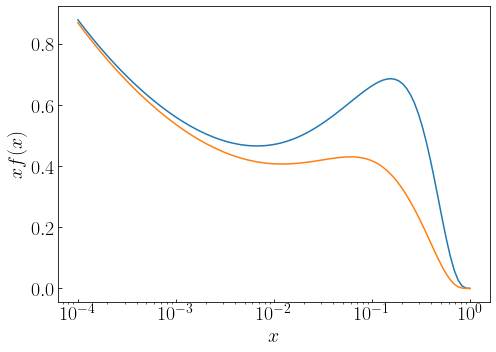

In [15]:
def test():
    pdf=conf['pdf']
    
    nrows,ncols=1,1
    fig = py.figure(figsize=(ncols*7,nrows*5))
    ax=py.subplot(nrows,ncols,1)

    x=10**np.linspace(-4,np.log10(0.99),100)
    Q2=10.0
    xu=[conf['pdf'].get_xF(_,Q2,'u') for _ in x]
    xd=[conf['pdf'].get_xF(_,Q2,'d') for _ in x]
    ax.plot(x,xu)
    ax.plot(x,xd)
    
    ax.semilogx()
    ax.set_xlabel(r'$x$',size=20)
    ax.set_ylabel(r'$xf(x)$',size=20)
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    #ax.text(0.6,0.2,r'$\mu_Q =Q=10 {\rm GeV}$',transform=ax.transAxes,size=20)
    py.tight_layout()

test()

In [16]:
class TMD_MODEL:
    """
    This class provides specific realization for nonperturbative behavior of TMDs
    """
    
    def __init__(self):
        self.aux=conf['aux']
        #- set constants
        self.Q0 = 1.3
        self.C1 = 2 * np.exp(-self.aux.euler)
        self.bmax=self.C1/self.Q0
        self.C2=1.0
        
        self.get_bstar=lambda bT: bT/np.sqrt(1+bT**2/self.bmax**2)
        self.get_mub=lambda bT: self.C1/self.get_bstar(bT)
    

### perturbative part of the evolution  (perturbative Sudakov and Collisn-Soper kernel)

In [17]:
class TMD_EVOLUTION_PERT:
    """
    This class sets up the perturbative Sudakov form factor
    we always need exp[S_pert] and it is calculated in perturbative regime
    """
    
    def __init__(self,order = 'NLL'):
        """
        order=LL, NLL, etc
        """
        if 'TMDorder' in conf: self.order=conf['TMDorder'][1] #--get resummation order
        else : self.order='NLL'
            
        if self.order=='LL':     self.iorder=0
        elif self.order=='NLL':  self.iorder=1
        elif self.order=='N2LL': self.iorder=2
        elif self.order=='N3LL': self.iorder=3
            
        self.setup()
        
    def setup(self):
        aux = conf['aux']
        self.alphaS=conf['alphaS']
  
        #--setup the evolution
        #self.euler=conf['aux'].euler
        #self.C1=conf['aux'].C1
        #self.bTmax=conf['aux'].bmax
        self.euler=conf['aux'].euler
        self.C1=conf['tmd_model'].C1
        self.C2=conf['tmd_model'].C2
        self.bmax=conf['tmd_model'].bmax
  
        # we will store all values of evolution
        self.storage={}
    
    #- Typical log in the expansion
    def get_Log(self,bT,mu):  
        return np.log(mu*bT/self.C1)
  
    #- Collins-Soper kernel at small bT can be expanded in alphaS, Eq. (69) of PhysRevD.96.054011
    def get_Ktilde(self,bT,mu):
        
        aS=self.alphaS.get_alphaS(mu**2)/(4*np.pi) #- alphaS/(4 pi)
        log=self.get_Log(bT,mu) #- Typical logarithm
        Nf=conf['alphaS'].get_Nf(mu**2) #- Number of flavors
        CF = conf['aux'].CF
        CA = conf['aux'].CA
        TR = conf['aux'].TR 
        zeta2 = zeta(2)
        zeta3 = zeta(3)
        zeta4 = zeta(4)
        zeta5 = zeta(5)
        pi = np.pi
        
        ##### for N3LL term - see 1604.07869 #####
        Gamma1 = 1
        Gamma2 = (67/9-pi**2/3)*CA - (20/9)*TR*Nf
        Gamma3 = CA**2*(245/6 - 134*pi**2/27 + 11*pi**4/45 + 22*zeta3/3) \
                    + CA*TR*Nf*(-418/27 + 40*pi**2/27 - 56*zeta3/3) \
                    + CF*TR*Nf*(-55/3 + 16*zeta3) - (16/27)*TR**2*Nf**2
        beta1 = (11/3)*CA - (4/3)*TR*Nf
        beta2 = 34*CA**2/3 - 20*CA*TR*Nf/3 - 4*CF*TR*Nf
        
        d20 = CA*(404/27 - 14*zeta3) - 112*TR*Nf/27
        d33 = (2/3)*Gamma1*beta1**2
        d32 = 2*Gamma2*beta1 + Gamma1*beta2
        d31 = 2*beta1*d20 + 2*Gamma3
        d30 = (-CA**2/2)*(-176*zeta3*zeta2/3 + 6392*zeta2/81 + 12328*zeta3/27 + 154*zeta4/3 - 192*zeta5 - 297029/729) \
                - CA*TR*Nf*(-824*zeta2/81 - 904*zeta3/27 + 20*zeta4/3 + 62626/729) \
                - 2*TR**2*Nf**2*(-32*zeta3/9 - 1856/729) \
                - CF*TR*Nf*(-304*zeta3/9 - 16*zeta4 + 1711/27)
        ######################################

        Ktilde = 0
    
        if self.iorder>0: 
            
            Ktilde += -8 * CF * aS * log
            
        if self.iorder>1:
            
            Ktilde += 8 * CF * aS**2 * (  \
                    +  (2./3. * Nf - 11./3. * CA) * log**2 \
                    +  (-67./9. * CA + pi**2/3. * CA + 10./9. * Nf) * log \
                    +  (7./2. * zeta3 - 101./27.) * CA + 14./27. * Nf )
            
        if self.iorder>2:
            
            Ktilde += -2*CF*aS**3 * (d30 +  2*log*d31 + 4*log**2*d32 + 8*log**3*d33) #see 1604.07869
            
        return Ktilde
    
        
    #- Anomalous dimension of TMD operator expanded in alphaS, Eq. (58) of PhysRevD.96.054011
    def get_gammaF(self,mu):
        
        aS=self.alphaS.get_alphaS(mu**2)/(4*np.pi) #- alphaS/(4 pi)
        Nf=conf['alphaS'].get_Nf(mu**2) #- Number of flavors
        CF = conf['aux'].CF
        CA = conf['aux'].CA
        TR = conf['aux'].TR 
        zeta2 = zeta(2)
        zeta3 = zeta(3)
        zeta4 = zeta(4)
        zeta5 = zeta(5)
        pi = np.pi
        
        gammaF = 0
        
        if self.iorder>0:
            
            gammaF += 6. * CF * aS
            
        if self.iorder>1:
            
            gammaF += aS**2 * ( CF**2 * (3. - 4. * pi**2 + 48. * zeta3)\
                    + CF * CA * (961./27. + 11. * pi**2/3. - 52. * zeta3)\
                    + CF * Nf * (-130./27. - 2. * pi**2/3.) )
            
        if self.iorder>2:
            
            gammaF += aS**3 * ( CF**2 * Nf * (-2953./27. + 26. * pi**2/9 + 28. * pi**4/27 - 512. * zeta3/9.)\
                    + CF * Nf**2 * (-4834./729. + 20. * pi**2/27. + 16. * zeta3/27. )\
                    + CF**3 * (29. + 6. * pi**2 + 16. * pi**4/5. + 136. * zeta3 - 32. * pi**2 * zeta3/3. - 480. * zeta5)\
                    + CA**2 * CF * (139345./1458. + 7163. * pi**2/243. + 83. * pi**4/45. - 7052. * zeta3/9. + 88. * pi**2 * zeta3/9. + 272. * zeta5 )\
                    + CA * CF * Nf * (17318./729. - 2594. * pi**2/243. - 22. * pi**4/45. + 1928. * zeta3/27.)\
                    + CA * CF**2 * (151./2. - 410. * pi**2/9. - 494. * pi**4/135. + 1688. * zeta3/3. + 16. * pi**2 * zeta3/3. + 240. * zeta5) )
        
        return gammaF
        
    #- Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
    def get_gammaK(self,mu):
        
        aS=self.alphaS.get_alphaS(mu**2)/(4*np.pi) #- alphaS/(4 pi)
        Nf=conf['alphaS'].get_Nf(mu**2) #- Number of flavors
        CF = conf['aux'].CF
        CA = conf['aux'].CA
        TR = conf['aux'].TR 
        zeta2 = zeta(2)
        zeta3 = zeta(3)
        zeta4 = zeta(4)
        zeta5 = zeta(5)
        pi = np.pi
        
        gammaK = 8. * CF * aS
        
        if self.iorder>0:
            
            gammaK += aS**2 * ( CA * CF * (536./9. - 8. * pi**2/3.)\
                    - 80./9. * CF * Nf )
            
        if self.iorder>1:
            
            gammaK += aS**3 * ( -32./27. * CF * Nf**2\
                + CA * CF * Nf * (-1672./27. + 160. * pi**2/27. - 224. * zeta3/3.)\
                + CA**2 * CF  * (980./3. - 1072. * pi**2/27. + 88. * pi**4/45. + 176. * zeta3/3.)\
                + CF**2 * Nf * (-220./3. + 64. * zeta3) )
            
        if self.iorder>2:
            
            gammaK += aS**4 * 2*(20702 - 5171.9*Nf + 195.5772*Nf**2 + 3.272344*Nf**3) 
                    # see 1707.08315: A4  = Gamm_cusp and gamma_K = 2*Gamma_cusp
                    # A4 = 20702(2) − 5171.9(2) nf + 195.5772 nf^2 + 3.272344 nf^3

        return gammaK
    
    #- perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_Evolution_exponent_perturbative(self,muQ,zeta,bT):
        
        mub=conf['tmd_model'].get_mub(bT)
        bstar=conf['tmd_model'].get_bstar(bT)

       
        key=(muQ,zeta,bstar)
        if key not in self.storage:
            self.storage[key]=np.log(np.sqrt(zeta)/mub)*self.get_Ktilde(bstar,mub) + quad(lambda mup: 1/mup*(self.get_gammaF(mup)-np.log(np.sqrt(zeta)/mup)*self.get_gammaK(mup)),mub,muQ)[0]

        return self.storage[key]

    #- Exponential of perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_exp_Evolution_exponent_perturbative(self,muQ,zeta,bT):
        
        return np.exp(self.get_Evolution_exponent_perturbative(muQ,zeta,bT)) 


           

### Nonperturbative evolution univeral part of Collins-Soper kernel at large bT

In [18]:
class TMD_EVOLUTION_UNIVERSAL_NONPERT:
    
    def __init__(self):
        conf['tmd_model'].g2=0.2  

    #- Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_gK(self,bT):
        g2=conf['tmd_model'].g2
        return bT * conf['tmd_model'].get_bstar(bT) * g2/2. 

    #- Exponential Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_exp_Evolution_universal_nonperturbative(self,zeta,bT):
        return np.exp( - self.get_gK(bT) * np.log(np.sqrt(zeta)/conf['tmd_model'].Q0) )



### Nonperturbative evolution intrinsic part for TMDPDF

In [19]:
class TMDPDF_EVOLUTION_INTRINSIC_NONPERT:
    
    def __init__(self):
        conf['tmd_pdf_model'].g1= 3.77759629e-01
        conf['tmd_pdf_model'].g3=-1.11608373e-01
        conf['tmd_pdf_model'].g4=1.65145977e-07

    #- Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_gJ(self,x,bT):
        g1=conf['tmd_pdf_model'].g1
        g3=conf['tmd_pdf_model'].g3
        g4=conf['tmd_pdf_model'].g4
        return (g1 + g3 * x) * bT**2/np.sqrt(1 + np.abs(g4) * x**2 * bT**2)
  
    #- Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_exp_Evolution_intrinsic_nonperturbative(self,x,Q,bT):
        return np.exp(-self.get_gJ(x,bT))


### Nonperturbative evolution intrinsic part for TMDFF

In [20]:
class TMDFF_EVOLUTION_INTRINSIC_NONPERT:
    
    def __init__(self):
        conf['tmd_ff_model'].g1FF= 3.77759629e-01
        conf['tmd_ff_model'].g3FF=-1.11608373e-01
        conf['tmd_ff_model'].g4FF=1.65145977e-07

    #- Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_gJ(self,z,bT):
        g1=conf['tmd_ff_model'].g1FF
        g3=conf['tmd_ff_model'].g3FF
        g4=conf['tmd_ff_model'].g4FF
        return (g1FF + g3FF * z) * bT**2/np.sqrt(1 + np.abs(g4FF) * z**2 * bT**2)
  
    #- Non perturbative part of the evolution in the solution maximizing perturbative precision, Eq. (26) of PhysRevD.96.054011
    def get_exp_Evolution_intrinsic_nonperturbative(self,z,Q,bT):
        return np.exp(-self.get_gJ(z,bT))

### hack parman to be tmd parmeters aware

In [21]:
class DEV_PARMAN(PARMAN):
    
    def propagate_params(self,semaphore):
        flag=False

        if 'QCD'       in semaphore and semaphore['QCD']      ==1: self.set_QCD_params()
        if 'eweak'     in semaphore and semaphore['eweak']    ==1: self.set_eweak_params()

        dists = []
        #--leading power collinear distributions
        dists.extend(['pdf','ppdf','ffpion','ffkaon','ffhadron'])
        #--pion pdfs
        dists.extend(['pdf-pion','pdf-pion-int'])
        #--special pdfs for lattice observables
        dists.extend(['pdf(qpdf)'])
        #--dis related objects
        dists.extend(['t3ppdf','ht4','pol ht4','off','pol off'])
        #--transverse momentum dependent distributions
        #dists.extend(['tmd','tmd-pion'])

        for dist in dists:
            if dist in semaphore and semaphore[dist]==1: self.set_dist_params(dist)

        #--spitting functions
        if 'p->pi,n'   in semaphore and semaphore['p->pi,n']  ==1: self.set_p_to_pi_n_params()

        #--finite volume effects
        if 'FV'        in semaphore and semaphore['FV']       ==1: self.set_FV_params()
            
        if 'tmd'       in semaphore and semaphore['tmd']      ==1: self.set_tmd_params()
        


    def set_tmd_params(self):
        conf['tmd_model'].g2=conf['params']['tmd']['g2']['value']
        conf['tmd_pdf_model'].g1=conf['params']['tmd']['g1']['value']
        conf['tmd_pdf_model'].g3=conf['params']['tmd']['g3']['value']
        conf['tmd_pdf_model'].g4=conf['params']['tmd']['g4']['value']
        conf['tmd_ff_model'].g1FF=conf['params']['tmd']['g1FF']['value']
        conf['tmd_ff_model'].g3FF=conf['params']['tmd']['g3FF']['value']
        conf['tmd_ff_model'].g4FF=conf['params']['tmd']['g4FF']['value']


        
    def gen_report(self):
        data={_:[] for _ in ['idx','dist','type','value']}
        cnt=0
        for k in conf['params']:
            for kk in sorted(conf['params'][k]):
                if  conf['params'][k][kk]['fixed']==False:
                    cnt+=1
                    data['idx'].append('%d'%cnt)
                    data['dist'].append('%10s'%k)
                    data['type'].append('%10s'%kk)
                    data['value'].append('%10.2e'%conf['params'][k][kk]['value'])
                    
        data=pd.DataFrame(data)
        msg=data.to_html(col_space=80,index=False,justify='left')
        return msg

In [22]:
conf['params']['tmd']={}
conf['params']['tmd']['g1']={'value': 3.77759629e-01, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd']['g2']={'value': 0.1,            'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd']['g3']={'value':-1.11608373e-01, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd']['g4']={'value': 1.65145977e-07, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd']['g1FF']={'value': 3.77759629e-01, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd']['g3FF']={'value':-1.11608373e-01, 'min':-1, 'max': 1, 'fixed': False}
conf['params']['tmd']['g4FF']={'value': 1.65145977e-07, 'min':-1, 'max': 1, 'fixed': False}

In [23]:
conf['tmd_model'] = TMD_MODEL() # all constants and functions will be here
conf['tmd_pdf_model']=TMDPDF_EVOLUTION_INTRINSIC_NONPERT() # parameters for intrinsis behavior of TMDPDF is here
conf['tmd_ff_model']=TMDFF_EVOLUTION_INTRINSIC_NONPERT() # parameters for intrinsis behavior of TMDFF is here
parman=DEV_PARMAN()
print(parman.par)
print(parman.order)

KeyError: 'tmd_pdf_model'

### Test

In [ ]:
conf['tmd_model'] = TMD_MODEL() # all constants and functions will be here
conf['tmd_pdf_model']=TMDPDF_EVOLUTION_INTRINSIC_NONPERT() # parameters for intrinsis behavior of TMDPDF is here
conf['tmd_ff_model']=TMDFF_EVOLUTION_INTRINSIC_NONPERT() # parameters for intrinsis behavior of TMDFF is here
conf['TMDorder']  = ('NLO','NLL') #--introduce tuple for (order,resummation order)
pert              = TMD_EVOLUTION_PERT()
nonpert_univ      = TMD_EVOLUTION_UNIVERSAL_NONPERT()
nonpert_intrin_pdf    = TMDPDF_EVOLUTION_INTRINSIC_NONPERT()
nonpert_intrin_ff     = TMDFF_EVOLUTION_INTRINSIC_NONPERT()

In [ ]:
def test():
    nrows,ncols=1,1
    fig = py.figure(figsize=(ncols*7,nrows*5))
    ax=py.subplot(nrows,ncols,1)

    bT=10**np.linspace(-2,1,50)
    x = 0.1
    z = 0.4
    Q = 10
    zeta = Q**2
    muQ=conf['tmd_model'].C2*Q
    expS1=[pert.get_exp_Evolution_exponent_perturbative(muQ,zeta,_) for _ in bT]
    
    expS2=[   pert.get_exp_Evolution_exponent_perturbative(muQ,zeta,_)\
           * nonpert_univ.get_exp_Evolution_universal_nonperturbative(zeta,_)\
           * nonpert_intrin_pdf.get_exp_Evolution_intrinsic_nonperturbative(x,Q,_)\
           * nonpert_intrin_ff.get_exp_Evolution_intrinsic_nonperturbative(z,Q,_) for _ in bT]
    
    ax.plot(bT,expS1,label=r'$\rm pert.$')
    ax.plot(bT,expS2,label=r'$\rm pert.+np$')
    ax.legend(loc=3,fontsize=20)
    ax.semilogx()
    ax.set_xlabel(r'$b_{\rm T} \; ({\rm GeV}^{-1})$',size=20)
    ax.set_ylabel(r'$\exp(S)(b_{\rm T})$',size=20)
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.text(0.05,0.3,r'$\mu_Q =Q=10~{\rm GeV}$',transform=ax.transAxes,size=20)
    py.tight_layout()

test()

### Let us construct now TMD PDF, the OPE part valid at small bT

In [ ]:
class TMDPDF_OPE_LHAPDF:
    
    def __init__(self,setname,iset=0):
        self.order=conf['TMDorder'][0] #--get fixed order
        if self.order=='LO': 
            self.iorder=0
        elif self.order=='NLO':
            self.iorder=1
            
        self.pdf=lhapdf.mkPDF(setname,iset)
        self.iflav=[5,4,3,2,1,-1,-2,-3,-4,-5]
        self.C1=conf['tmd_model'].C1
    
    #- Typical log in the expansion
    def get_Log(self,bT,mu):  
        return np.log(mu*bT/self.C1)
    
    def _get_NLOq_integrand(self,xh,mu,x,bT,flav,zeta):
        aS=conf['alphaS'].get_alphaS(mu**2)
        Log=self.get_Log(bT,mu)
        PDF=self.pdf.xfxQ2(flav,x/xh,mu**2)/(x/xh)
        term1=-2*Log*(2.0/(1-xh)*(PDF/xh-self.pdf.xfxQ2(flav,x,mu**2)/x)-PDF/xh*(1+xh))
        term2=PDF/xh*(1-xh)
        term3=1.0/(1-x)*(self.pdf.xfxQ2(flav,x,mu**2)/x*(-2*Log**2-2*Log*np.log(zeta/mu**2)))
        return term1+term2+term3
    
    def _get_NLOg_integrand(self,xh,mu,x,bT):
        aS=conf['alphaS'].get_alphaS(mu**2)
        PDF=self.pdf.xfxQ2(21,x/xh,mu**2)/(x/xh)
        return PDF/xh*(-self.get_Log(bT,mu)*(1-2*xh*(1-xh))+xh*(1-xh))
    
    def get_OPE(self,x,bT,zeta):
        # For LL and NLL it is relatively easy, NNLL will require some work    
        mub=conf['tmd_model'].get_mub(bT)
        
        CF=conf['aux'].CF
        TF=conf['aux'].TF
        
        data={_: self.pdf.xfxQ2(_,x,mub**2)/x for _ in self.iflav} # Notice that a dictionary is returned, [flavor: pdf(x)]
        
        if self.iorder>0:
            
            aS=conf['alphaS'].get_alphaS(mub**2)
            
            for k in self.iflav:
                
                NLOq=aS*CF/2.0/np.pi*fixed_quad(np.vectorize(lambda xh: self._get_NLOq_integrand(xh,mub,x,bT,k,zeta)), x, 1, n=100)[0]
                NLOg=aS*TF/np.pi*fixed_quad(np.vectorize(lambda xh: self._get_NLOg_integrand(xh,mub,x,bT)), x, 1, n=100)[0]
                data[k] += NLOq + NLOg

        return data


class TMDPDF_OPE:
    
    def __init__(self,mellin=None,collinear='pdf'):
        self.order=conf['TMDorder'][0] #--get fixed order
        
        if self.order=='LO': 
            self.iorder=0
        elif self.order=='NLO':
            self.iorder=1
        
        self.fmap={5:'b',4:'c',3:'s',2:'u',1:'d',-1:'db',-2:'ub',-3:'sb',-4:'cb',-5:'bb'}#,21:'g'}
        if mellin==None: self.mellin=conf['mellin']
        else: self.mellin=mellin
        self.pdf=conf[collinear]
        self.euler=conf['aux'].euler
        self.C1=conf['tmd_model'].C1
        self.storage={}
    
    #- Typical log in the expansion
    def get_Log(self,bT,mu):  
        return np.log(mu*bT/self.C1)
    
    def get_CqN(self,bT,zeta):
        
        N=self.mellin.N
        CF=conf['aux'].CF
        
        mub=conf['tmd_model'].get_mub(bT)
        aS=conf['alphaS'].get_alphaS(mub**2)
        Log=self.get_Log(bT,mub)
        LO=np.ones(len(N))
        mell1=np.array([1.0/n+1.0/(n+1)+2*self.euler for n in N]) + 2*conf['aux'].get_psi(0,N)
        mell2=np.array([1.0/n-1.0/(n+1) for n in N])
        NLO=aS*CF/2.0/np.pi*(-2*Log**2-2*Log*np.log(zeta/mub**2)+2*Log*(mell1)+mell2)
        return LO+NLO
    
    def get_CgN(self,bT):
        
        N=self.mellin.N
        TF=conf['aux'].TF
        
        mub=conf['tmd_model'].get_mub(bT)
        aS=conf['alphaS'].get_alphaS(mub**2)
        Log=self.get_Log(bT,mub)
        mell1=np.array([1.0/n-2.0/(n+1)+2.0/(n+2) for n in N])
        mell2=np.array([1.0/(n+1)-1.0/(n+2) for n in N])
        return aS*TF/np.pi*(-Log*mell1+mell2)
    
    #- For LL and NLL it is relatively easy, NNLL will require some work    
    def get_OPE(self,x,bT,zeta):
        mub=conf['tmd_model'].get_mub(bT)
        if self.order == 'LO': 
            data={_:self.pdf.get_xF(x,mub**2,self.fmap[_])/x for _ in self.fmap}
        elif self.order == 'NLO':
            aS=conf['alphaS'].get_alphaS(mub**2)
            self.pdf.evolve(mub**2)
            lenN=len(self.mellin.N)
            data={_:0 for _ in self.fmap}
            qkey=(bT,zeta,'q')
            if qkey not in self.storage:
                self.storage[qkey]=self.get_CqN(bT,zeta)
            CqN=self.storage[qkey]
            gkey=(bT,'g')
            if gkey not in self.storage:
                self.storage[gkey]=self.get_CgN(bT)
            CgN=self.storage[gkey]
            for k in self.fmap:
                CFN=CqN*self.pdf.storage[mub**2][self.fmap[k]] + CgN*self.pdf.storage[mub**2]['g']
                data[k]=self.mellin.invert(x,CFN)
        return data

### Let us construct now TMD FF, the OPE part valid at small bT

In [ ]:
class TMDFF_OPE:
    
    def __init__(self,mellin=None,collinear='ff'):
        self.order=conf['TMDorder'][0] #--get fixed order
        
        if self.order=='LO': 
            self.iorder=0
        elif self.order=='NLO':
            self.iorder=1
        
        self.fmap={5:'b',4:'c',3:'s',2:'u',1:'d',-1:'db',-2:'ub',-3:'sb',-4:'cb',-5:'bb'}#,21:'g'}
        if mellin==None: self.mellin=conf['mellin']
        else: self.mellin=mellin
        self.pdf=conf[collinear]
        self.euler=conf['aux'].euler
        self.C1=conf['tmd_model'].C1
        self.storage={}
    
    #- Typical log in the expansion
    def get_Log(self,bT,mu):  
        return np.log(mu*bT/self.C1)
    
    def get_CqN(self,bT,zeta):
        
        N=self.mellin.N
        CF=conf['aux'].CF
        
        mub=conf['tmd_model'].get_mub(bT)
        alphaS=conf['alphaS'].get_alphaS(mub**2)
        Log=self.get_Log(bT,mub)
        LO=np.ones(len(N))
        mell1=np.array([1.0/n+1.0/(n+1)-2*self.euler for n in N]) - 2*conf['aux'].get_psi(0,N+2)
        mell2=np.array([1.0/n-1.0/(n+1) for n in N])
        mell3 = 2*(-2*conf['aux'].get_psi(1,N+2)-np.array([1.0/n**2-1.0/(n+1)**2 for n in N]))
        NLO=alphaS*CF/2.0/np.pi*(-2*Log**2-2*Log*np.log(zeta/mub**2)-2*Log*(mell1)+mell2+mell3)
        return LO+NLO
    
    def get_CgN(self,bT):
        
        N=self.mellin.N
        TF=conf['aux'].TF
        
        mub=conf['tmd_model'].get_mub(bT)
        alphaS=conf['alphaS'].get_alphaS(mub**2)
        Log=self.get_Log(bT,mub)
        mell1=np.array([(n**2+n+2)/(n*(n**2-1)) for n in N])
        mell2=np.array([2/n**2-1/(n+1)**2-2/(n-1)**2 for n in N])
        mell3 = np.array([1/(n+1) for n in N])
        return alphaS*CF/2.0/np.pi*(-2*Log*mell1+2*mell2+mell3)
    
    #- For LL and NLL it is relatively easy, NNLL will require some work    
    def get_OPE(self,z,bT,zeta):
        mub=conf['tmd_model'].get_mub(bT)
        if self.order == 'LO': 
            data={_:self.ff.get_xF(z,mub**2,self.fmap[_])/z**3 for _ in self.fmap}
        elif self.order == 'NLO':
            alphaS=conf['alphaS'].get_alphaS(mub**2)
            self.ff.evolve(mub**2)
            lenN=len(self.mellin.N)
            data={_:0 for _ in self.fmap}
            qkey=(bT,zeta,'q')
            if qkey not in self.storage:
                self.storage[qkey]=self.get_CqN(bT,zeta)
            CqN=self.storage[qkey]
            gkey=(bT,'g')
            if gkey not in self.storage:
                self.storage[gkey]=self.get_CgN(bT)
            CgN=self.storage[gkey]
            for k in self.fmap:
                CFN=CqN*self.ff.storage[mub**2][self.fmap[k]] + CgN*self.ff.storage[mub**2]['g']
                data[k]=self.mellin.invert(z,CFN/z**2)
        return data

In [ ]:
def test():
    tmp=TMD_OPE_LHAPDF('EPPS16nlo_CT14nlo_Pt195')
    print(tmp.get_OPE(0.1,0.1,10))
    tmp=TMD_OPE()
    print(tmp.get_OPE(0.1,0.1,10))
test()

Hard factor Drell-SIDIS

In [ ]:
class HARD_FACTOR_SIDIS:
    
    def __init__(self):

        if 'TMDorder' in conf: self.order=conf['TMDorder'][0] #--get fixed order
        else : self.order='NLO'
            
        if self.order=='LO':
            self.iorder=0
        elif self.order=='NLO':
            self.iorder=1
        elif self.order=='N2LO':
            self.iorder=2
       
        
    def get_Hard_factor(self,muQ,Q):
        #-- Hard facror Eq. (63) of PhysRevD.96.054011
        
        aS=conf['alphaS'].get_alphaS(muQ**2)/(4*np.pi) #- alphaS/(4 pi)
        Nf=conf['alphaS'].get_Nf(muQ**2) #- Number of flavors
        CF=conf['aux'].CF
        CA=conf['aux'].CA

        T=np.log(Q**2/muQ**2)
        
        Hard_factor=1
        
        if self.iorder>0:
            
            Hard_factor += CF * aS * (-16 + np.pi**2/3 + 6* T - 2* T**2)
            
        if self.iorder>1:
            
            Hard_factor += aS**2 * (CF**2 * (511./4. + 13. * np.pi**2/3. - 13. * np.pi**4/30. - 60. * zeta(3)\
                        + T*( -93. - 2. * np.pi**2 + 48. * zeta(3)) + T**2 * (-2. * np.pi**2/3. + 50.) - 12. * T**3 + 2 * T**4)\
                        + CF * CA * (-51157./324. - 337. * np.pi**2/54. + 22. * np.pi**4/45. + 626. * zeta(3)/9.\
                        + T*(2545./27 + 22.*np.pi**2/9. - 52. * zeta(3)) + T**2 * (2.*np.pi**2/3. - 233./9.) + 22./9. * T**3)\
                        + Nf * CF * (4085./162. + 23.*np.pi**2/27. + 4. * zeta(3)/9. - T*(4. * np.pi**2/9. + 418./27.)\
                        + 38./9. * T**2 - 4./9. * T**3) )
            
        return Hard_factor   

### Now we are ready to construct observables and W term

In [ ]:
class WTERM_SIDIS:
    def __init__(self):
        
        self.tmdpdf=TMD_OPE()
        self.tmff=TMD_OPE_LHAPDF('EPPS16nlo_CT14nlo_Pt195')
        self.tmd_evolution_pert=TMD_EVOLUTION_PERT()
        self.tmd_evolution_nonpert=TMD_EVOLUTION_UNIVERSAL_NONPERT()
        self.tmdpdf_evolution_nonpert=TMDPDF_EVOLUTION_INTRINSIC_NONPERT()
        self.tmdff_evolution_nonpert=TMDFF_EVOLUTION_INTRINSIC_NONPERT()
        self.Hard_factor=HARD_FACTOR_SIDIS()
        self.Astorage={} #--Since A not fitted, calculate on first iteration and store
        self.Bstorage={} #--Since B not fitted, calculate on first iteration and store
        
    def Wtilde(self,bT,Q,x,z):
        tmdPDF=self.tmdpdf
        tmdFF=self.tmdff
        muQ = conf['tmd_model'].C2*Q
        hard_factor = self.Hard_factor.get_Hard_factor(muQ,Q)
        Nf=conf['alphaS'].get_Nf(Q**2)
        #- OPE part calculation
        zeta=Q**2
        keyOPE=(x,z,bT,Nf,zeta)
        if keyOPE not in self.Astorage:
            tmdAflav = tmdPDF.get_OPE(x, bT, zeta)
            tmdBflav = tmdFF.get_OPE(z, bT, zeta)
            # u = 2, ub =-2
            # d = 1, db =-1
            # s = 3, sb =-3
            OPE = (4.0/9.0)*tmdAflav[ 2]*tmdBflav[ 2]\
             +(4.0/9.0)*tmdAflav[-2]*tmdBflav[-2]\
             +(1.0/9.0)*tmdAflav[ 1]*tmdBflav[ 1]\
             +(1.0/9.0)*tmdAflav[-1]*tmdBflav[-1]\
             +(1.0/9.0)*tmdAflav[ 3]*tmdBflav[ 3]\
             +(1.0/9.0)*tmdAflav[-3]*tmdBflav[-3]
            if Nf>3: 
                OPE += (4.0/9.0)*(tmdAflav[ 4]*tmdBflav[ 4]+tmdAflav[-4]*tmdBflav[-4]) #--c,cb+cb,c
            if Nf>4: 
                OPE += (1.0/9.0)*(tmdAflav[ 5]*tmdBflav[ 5]+tmdAflav[-5]*tmdBflav[-5]) #--b,bb+bb,b
            self.Astorage[keyOPE]=OPE
        OPE=self.Astorage[keyOPE]
        #- Perturbative Sudakov calculation    
        keySUDAKOV = (zeta,bT)
        if keySUDAKOV not in self.Bstorage:
            SUDAKOV=pert.get_exp_Evolution_exponent_perturbative(muQ,zeta,bT)**2 #- **2 because we have this part from both A and B
            self.Bstorage[keySUDAKOV] = SUDAKOV
        SUDAKOV = self.Bstorage[keySUDAKOV]
        #- Non perturbative Sudakov and intrinsic calculation
        SUDAKOVNP =  self.tmd_evolution_nonpert.get_exp_Evolution_universal_nonperturbative(zeta,bT)**2 \
                   * self.tmdpdf_evolution_nonpert.get_exp_Evolution_intrinsic_nonperturbative(x,Q,bT)\
                   * self.tmdff_evolution_nonpert.get_exp_Evolution_intrinsic_nonperturbative(z,Q,bT) 
        return hard_factor * OPE * SUDAKOV * SUDAKOVNP
    
    def setup(self,Q,x,z):
        self.bT=10**np.linspace(-5,2,100)
        self.storage_Wtilde=np.array([self.Wtilde(_,Q,x,z) for _ in self.bT])
        
    def get_FUU(self,pT,Q,s,x,z,par=[[False],[False],[False]]):
        y = s/(Q*Q*x) # TODO add the correct formula here
        qT = pT/z     # TODO add the correct formula here
        born=conf['eweak'].get_alpha(Q**2)**2/x/y/Q/Q * (1 - y + y**2/2)
        Wtilde = interpolate.interp1d(self.bT,self.storage_Wtilde,fill_value=0,bounds_error=False) #--interpolated from self.bT
        W=1./2./np.pi*fixed_quad(np.vectorize(lambda bT: bT*jv(0,qT*bT)*Wtilde(bT)),1e-2,1e2,n=100)[0] #--integrate over interpolated function
        return born*W
    
            

In [ ]:
#maxlike.run_fit()

In [ ]:
#maxlike.resman=None

In [ ]:
#less /work/JAM/barryp/JAM/fitpack2/fitlib/maxlike.py

In [ ]:
#less /work/JAM/barryp/JAM/fitpack2/fitlib/parman.py

In [ ]:
#less /work/JAM/barryp/JAM/fitpack2/fitlib/resman.py

In [ ]:
#less /work/JAM/barryp/JAM/fitpack2/fitlib/maxlike.py